In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 讀取 libraries
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
%matplotlib inline

from keras import Input
from keras.models import Model
from keras.layers import Dense, Dropout, Conv2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import legacy
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import Xception

import os
# 設定當前工作目錄
path="/content/drive/MyDrive/wafer/"
os.chdir(path)

import warnings
warnings.filterwarnings("ignore")

In [3]:
# 讀取資料(npz壓縮檔)
df=np.load('rawdata.npz')
X_train = df['X_train']
y_train = df['y_train']
df.close()

In [4]:
# 模型架構 (Xception)
def build_xception():
    xception = Xception(weights='imagenet', include_top=False)

    input = Input(shape=(64, 64, 3))
    x = Conv2D(3, (3, 3), padding='same')(input)

    x = xception(x)

    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(8, activation = 'softmax')(x)

    # model
    model = Model(input ,output)

    optimizer = legacy.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()

    return model

In [5]:
# 呼叫模型
model = build_xception()
# EarlyStopping：可設定訓練提早結束的條件。
es = EarlyStopping(monitor='val_accuracy', mode='auto', verbose=1, patience=10)
# ReduceLROnPlateau：當訓練已無改善時，可以降低學習率，追求更細微的改善，找到更精準的最佳解。
Reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
# ModelCheckpoint：由於訓練過程耗時，有可能訓練一半就當掉，因此，我們可以利用這個 Callback，在每一個檢查點(Checkpoint)存檔，下次執行時，就可以從中斷點繼續訓練。
checkpoint = ModelCheckpoint('wafer_detection_xception_model.h5', verbose=1, save_best_only=True)

# 訓練資料
History = model.fit(X_train, y_train,
           epochs=100,
           batch_size=64,
           verbose=2,
           callbacks=[Reduce, es, checkpoint],
           validation_split=0.2, # 每次訓練將 Train data 分割 20% 作為 Validation data
           workers=8)

83683744/83683744 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 3)         84        
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                              

In [6]:
model_path = os.path.join(path, "model/Xception")
model.save(model_path)

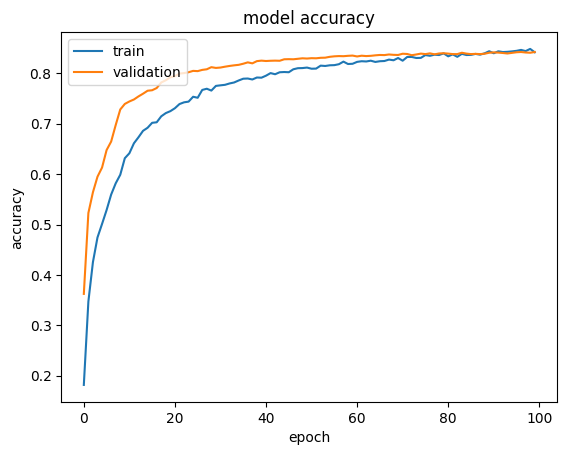

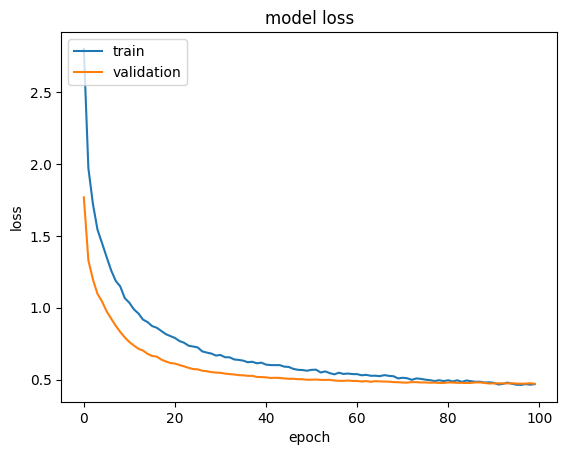

In [7]:
# Accuracy plot
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss plot
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()